# GPFlow
Use this script: Import the packages, load the packages and load the helperfunctions and then go down to "Set up the Ensemble Workflow" where everything should be explained and self-contained. Code above might be useful in the future but not necessary.

In [2]:
#%%capture 
#suppresses output

#!pip install gpflow
#!pip install folium
#!pip install seaborn
#!pip install matplotlib --upgrade

In [4]:
from typing import Sequence

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import statistics
import seaborn as sns
import tensorflow as tf

import gpflow

import os

from scipy.cluster.vq import kmeans

import folium
from folium.plugins import HeatMap
import branca.colormap as cm
from branca.colormap import linear

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm

import pickle

#%matplotlib notebook
%matplotlib

Using matplotlib backend: nbAgg


### Helpers

In [5]:
def plot_2d_model(model: gpflow.models.GPModel) -> None:
    n_grid = 50
    _, (ax_mean, ax_std) = plt.subplots(nrows=1, ncols=2, figsize=(11, 5))
    Xplots = np.linspace(0.0, 1.0, n_grid)
    Xplot1, Xplot2 = np.meshgrid(Xplots, Xplots)
    Xplot = np.stack([Xplot1, Xplot2], axis=-1)
    Xplot = Xplot.reshape([n_grid ** 2, 2])

    iv = getattr(model, "inducing_variable", None)
    # Do not optimize inducing variables, so that we can better see the impact their choice has. When solving
    # a real problem you should generally optimise your inducing points.
    if iv is not None:
        gpflow.set_trainable(iv, False)
    opt = gpflow.optimizers.Scipy()
    opt.minimize(model.training_loss, model.trainable_variables)

    y_mean, y_var = model.predict_y(Xplot)
    y_mean = y_mean.numpy()
    y_std = tf.sqrt(y_var).numpy()

    ax_mean.pcolor(Xplot1, Xplot2, y_mean.reshape(Xplot1.shape))
    ax_std.pcolor(Xplot1, Xplot2, y_std.reshape(Xplot1.shape))
    ax_mean.scatter(X[:, 0], X[:, 1], s=50, c="black")
    ax_std.scatter(X[:, 0], X[:, 1], s=50, c="black")

    # Also plot the inducing variables if possible:
    if iv is not None:
        ax_mean.scatter(iv.Z[:, 0], iv.Z[:, 1], marker="x", color="red")

In [6]:
def compute_z_values(predictions, true_values, std_err):
    y_median = np.full(predictions.shape, median_pm25_detrended_15)
    z_values = (predictions - y_median) / np.array(std_err)
    return z_values

In [7]:
def calculate_pollution_levels(tiles_df):
    tile_stats = tiles_df.groupby("tile_id")["pm25_detrended_15"].agg(["mean", "std"]).reset_index()
    tiles_df = tiles_df.merge(tile_stats, on = "tile_id")
    tiles_df["pollution_level"] = (tiles_df["pm25_detrended_15"] - tiles_df["mean"]) / tiles_df["std"]
    return tiles_df

In [8]:
def stratified_sampling(df, p_low, p_high, sample_frac_low, sample_frac_medium,
                        sample_frac_high, add_covariates, response, size_subsample):
    
    # Calculate the pollution levels for each tile
    df_poll = calculate_pollution_levels(df)
    df_poll = df_poll.dropna(subset=["pollution_level"])

    # Calculate the percentile pollution levels and split into groups
    p_low_value = np.percentile(df_poll["pollution_level"], p_low)
    p_high_value = np.percentile(df_poll["pollution_level"], p_high)

    low_pollution_tiles = df_poll[df_poll["pollution_level"] < p_low_value]
    medium_pollution_tiles = df_poll[(df_poll["pollution_level"] >= p_low_value) & (df_poll["pollution_level"] < p_high_value)]
    high_pollution_tiles = df_poll[df_poll["pollution_level"] > p_high_value]

    # Determine the sample size for each stratum
    total_sample_size = size_subsample * (sample_frac_low + sample_frac_medium + sample_frac_high)
    low_pollution_sample_size = int(total_sample_size * sample_frac_low)
    medium_pollution_sample_size = int(total_sample_size * sample_frac_medium)
    high_pollution_sample_size = int(total_sample_size * sample_frac_high)

    # Use stratified random sampling to select samples from each stratum
    low_pollution_sample = low_pollution_tiles.sample(n=low_pollution_sample_size, replace=False)
    medium_pollution_sample = medium_pollution_tiles.sample(n=medium_pollution_sample_size, replace=False)
    high_pollution_sample = high_pollution_tiles.sample(n=high_pollution_sample_size, replace=False)

    # Combine the samples from each stratum to obtain the final sample
    final_sample = pd.concat([low_pollution_sample, medium_pollution_sample, high_pollution_sample])
    
    # Get the X and Y arrays
    if add_covariates == False:
        X = final_sample[["lat","lon"]].to_numpy()
    else: 
        X= final_sample[["lat", "lon", "industrial", "major.road", "res.road"]].to_numpy()
    
    Y = final_sample[[response]].to_numpy()
    return X, Y

In [9]:
def plot_ensemble(z_value_or_pred):
    
    # Create df with predictions and z_values
    if z_value_or_pred == "pred":
        values = ensemble_mean
        col_name = "pred"
    elif z_value_or_pred == "z_val":
        values = (ensemble_mean-median_pm25)/np.sqrt(ensemble_var)
        col_name = "z_val"
    else:
        raise ValueError("z_value_or_pred should be 'pred' or 'z_val'")
    val_df = pd.DataFrame(values)
    X_test_df = pd.DataFrame(X_test)
    df_plot = pd.concat([val_df, X_test_df], axis=1)
    df_plot.columns = [col_name, "latitude", "longitude"]

    # Set map location and zoom level
    mean_lat = 0.5*(min_lat+max_lat)
    mean_lon = 0.5*(min_lon+max_lon)
    m = folium.Map(location=[mean_lat, mean_lon], zoom_start=13)

    # Create heatmap layer
    heatmap = HeatMap(data=df_plot[["latitude", "longitude", col_name]].values.tolist(),
                      radius=15)
    heatmap.add_to(m)

    # Create colorbar
    cmap = cm.LinearColormap(["blue", "green", "red"], vmin=df_plot[col_name].min(), vmax=df_plot[col_name].max())
    colorbar = cmap.to_step(10)
    colorbar.caption = "Z Values" if z_value_or_pred == "z_val" else "Predictions"

    # Add the colorbar to the map
    for i in range(0, 10):
        colorbar.add_to(m)

    # Add circle markers for extreme values 
    for lat, lon, val in zip(df_plot["latitude"], df_plot["longitude"], df_plot[col_name]):
        if abs(val) >= 2.575:
            folium.CircleMarker(
                location=[lat, lon],
                radius=0.1,
                color='black',
                fill=True,
                fill_color='black'
            ).add_to(m)

    return m

In [10]:
# Not necessary overall, lets just predict for the entire city. Problem was the lengthscale of 0 and not the areas with
# no observations. Also very slow (could increase increments though).
def find_coverage_area(data, percent_coverage): 
    total_count = len(data)
    target_count = round(total_count * percent_coverage)
    center_lon = (np.min(data["lon"])+np.max(data["lon"]))/2
    center_lat = (np.min(data["lat"])+np.max(data["lat"]))/2

    count = 0
    max_lon = center_lon
    min_lon = center_lon
    max_lat = center_lat
    min_lat = center_lat

    while count < target_count:
        count = len(data[(data["lon"] >= min_lon) & (data["lon"] <= max_lon) &
                         (data["lat"] >= min_lat) & (data["lat"] <= max_lat)])
        if count < target_count:
            if (max_lon - center_lon) > (center_lon - min_lon):
                max_lon += 0.001
            else:
                min_lon -= 0.001

            if (max_lat - center_lat) > (center_lat - min_lat):
                max_lat += 0.001
            else:
                min_lat -= 0.001

    return pd.DataFrame({"min_longitude": [min_lon], "max_longitude": [max_lon],
                         "min_latitude": [min_lat], "max_latitude": [max_lat]})

### Data stuff

In [11]:
#os.chdir("C:/Users/eminu/OneDrive/Desktop/Air-Quality-StatsLab/Data/Rawdata")
os.chdir(r"C:\Users\nial\OneDrive\Documents\ETH-Zürich-DESKTOP-9E8KBS8\AQ Data Collection")

In [12]:
df = pd.read_csv("data_cleaned_final.csv")
df_subsampled = df.sample(frac = 0.01)
median_pm25_detrended_15 = np.median(df[["pm25_detrended_15"]])
df

lat        lon   pm25      Date    Time  \
0       -1.969323  30.087935  83.34  20210901   73415   
1       -1.969321  30.087935  83.21  20210901   73416   
2       -1.969320  30.087935  82.96  20210901   73418   
3       -1.969321  30.087935  82.89  20210901   73419   
4       -1.969313  30.087939  82.87  20210901   73420   
...           ...        ...    ...       ...     ...   
2023781 -1.941188  30.037972  44.19  20210920  212943   
2023782 -1.941200  30.037972  43.71  20210920  212947   
2023783 -1.941211  30.037976  43.65  20210920  212949   
2023784 -1.941218  30.037976  43.60  20210920  212950   
2023785 -1.941224  30.037980  43.40  20210920  212951   

                            device  Speed     Date_ft   Time_ft  \
0        SPS30_SN:32CAA64C1161ED99    0.8  2021-09-01  07:34:15   
1        SPS30_SN:32CAA64C1161ED99    0.4  2021-09-01  07:34:16   
2        SPS30_SN:32CAA64C1161ED99    0.3  2021-09-01  07:34:18   
3        SPS30_SN:32CAA64C1161ED99    0.6  2021-09-01  07:34:19   
4        SPS30_SN:32CAA64C1161ED99    0.2  2021-09-01  07:34:20   
...                            ...    ...         ...       ...   
2023781  SPS30_SN:A5751625E3588897    0.9  2021-09-20  21:29:43   
2023782  SPS30_SN:A5751625E3588897    1.0  2021-09-20  21:29:47   
2023783  SPS30_SN:A5751625E3588897    2.1  2021-09-20  21:29:49   
2023784  SPS30_SN:A5751625E3588897    1.8  2021-09-20  21:29:50   
2023785  SPS30_SN:A5751625E3588897    2.0  2021-09-20  21:29:51   

                     datetime  ...  trajectory_id  baseline_15  baseline_day  \
0        2021-09-01T05:34:15Z  ...              1       83.340        83.340   
1        2021-09-01T05:34:16Z  ...              1       83.275        83.275   
2        2021-09-01T05:34:18Z  ...              1       83.210        83.210   
3        2021-09-01T05:34:19Z  ...              1       83.085        83.085   
4        2021-09-01T05:34:20Z  ...              1       82.960        82.960   
...                       ...  ...            ...          ...           ...   
2023781  2021-09-20T19:29:43Z  ...             79       43.220        32.890   
2023782  2021-09-20T19:29:47Z  ...             79       43.220        32.890   
2023783  2021-09-20T19:29:49Z  ...             79       43.220        32.890   
2023784  2021-09-20T19:29:50Z  ...             79       43.225        32.890   
2023785  2021-09-20T19:29:51Z  ...             79       43.230        32.890   

         pm25_detrended_15  pm25_detrended_day  pm25_detrended_comb  tile_id  \
0                    0.000               0.000               0.0000  35950.0   
1                   -0.065              -0.065              -0.0650  35950.0   
2                   -0.250              -0.250              -0.2500  35950.0   
3                   -0.195              -0.195              -0.1950  35950.0   
4                   -0.090              -0.090              -0.0900  35950.0   
...                    ...                 ...                  ...      ...   
2023781              0.970              11.300               6.1350  40485.0   
2023782              0.490              10.820               5.6550  40485.0   
2023783              0.430              10.760               5.5950  40485.0   
2023784              0.375              10.710               5.5425  40485.0   
2023785              0.170              10.510               5.3400  40485.0   

         industrial  major.road  res.road  
0                 0           0         0  
1                 0           0         0  
2                 0           0         0  
3                 0           0         0  
4                 0           0         0  
...             ...         ...       ...  
2023781           0           0         0  
2023782           0           0         0  
2023783           0           0         0  
2023784           0           0         0  
2023785           0           0         0  

[2023786 rows x 22 columns]

In [13]:
dummy_df = pd.get_dummies(df_subsampled["device"], prefix = "device")
df_subsampled = pd.concat([df_subsampled, dummy_df], axis = 1)
df_subsampled = df_subsampled.drop("device", axis = 1)

X_large = pd.concat([df_subsampled.filter(regex="device_*"), df_subsampled[["lat", "lon", "industrial", "major.road",
                  "res.road"]]], axis = 1).to_numpy()
X = df_subsampled[["lat","lon"]].to_numpy()
Y = df_subsampled[["pm25_detrended_15"]].to_numpy()

In [14]:
# Try stratified sampling. Try something more elaborate later. Make function out of that and use it for the ensemble.

# Calculate the pollution levels for each tile
df_poll = calculate_pollution_levels(df)
df_poll = df_poll.dropna(subset=["pollution_level"]) # think about that

# Calculate the 20th and 80th percentile pollution levels and split into groups
p20 = np.percentile(df_poll["pollution_level"], 20)
p80 = np.percentile(df_poll["pollution_level"], 80)

low_pollution_tiles = df_poll[df_poll["pollution_level"] < p20]
medium_pollution_tiles = df_poll[(df_poll["pollution_level"] >= p20) & (df_poll["pollution_level"] < p80)]
high_pollution_tiles = df_poll[df_poll["pollution_level"] > p80]

# Determine the sample size for each stratum
total_sample_size = 2000
low_pollution_sample_size = int(total_sample_size * 0.3)
medium_pollution_sample_size = int(total_sample_size * 0.4)
high_pollution_sample_size = int(total_sample_size * 0.3)

# Use stratified random sampling to select samples from each stratum
low_pollution_sample = low_pollution_tiles.sample(n=low_pollution_sample_size, replace=False)
medium_pollution_sample = medium_pollution_tiles.sample(n=medium_pollution_sample_size, replace=False)
high_pollution_sample = high_pollution_tiles.sample(n=high_pollution_sample_size, replace=False)

# Combine the samples from each stratum to obtain the final sample
final_sample = pd.concat([low_pollution_sample, medium_pollution_sample, high_pollution_sample])

In [19]:
plt.hist(final_sample[["pollution_level"]], bins = 20)
plt.show()
plt.savefig("hist_of_pollution_sample.jpeg")
#np.mean(final_sample[["pollution_level"]])

<IPython.core.display.Javascript object>

In [17]:
# Create X and Y
X = final_sample[["lat","lon"]].to_numpy()
Y = final_sample[["pm25_detrended_15"]].to_numpy()

In [20]:
df_poll = calculate_pollution_levels(df)
sum(df_poll["std"].isnull()) # 139
df_poll
plt.hist(df_poll[["pollution_level"]], bins = 100)
plt.savefig("hist_of_pollution.jpeg") #plt.show() not showing in VSCode, so I save figs instead
plt.show()

<IPython.core.display.Javascript object>

### Train model
Choose one of the models below (either sparse GP but with exact inference or sparse GP with variational inference)

In [18]:
# Init inducing points and model. Sparse model.
n_inducing = 1000
inducing_variable, _ = kmeans(X, n_inducing)

model = gpflow.models.SGPR(
    (X, Y),
    kernel=gpflow.kernels.Exponential(),
    inducing_variable=inducing_variable,
)
opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables)

gpflow.utilities.print_summary(model, "notebook")

In [21]:
len(X)

2000

In [29]:
# Init inducing points and model. Look at difference of loss_closure and without. Sparse Variational model.
n_inducing = 5000 
inducing_variable, _ = kmeans(X, n_inducing) #doesn't run if final sample is 2000 obs 

model = gpflow.models.SVGP(
    kernel=gpflow.kernels.Exponential(),
    likelihood=gpflow.likelihoods.Gaussian(),
    inducing_variable=inducing_variable,
)
opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss_closure((X, Y)), model.trainable_variables)

gpflow.utilities.print_summary(model, "notebook")

ValueError: Cannot take a larger sample than population when 'replace=False'

In [21]:
# Normal GP
model = gpflow.models.GPR(
    (X, Y),
    kernel=gpflow.kernels.Exponential(),
)

opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables)

gpflow.utilities.print_summary(model, "notebook")

_Niál note: terminated training after 1000 iterations; no change to training loss_

In [34]:
# Train the model using Keras directly so we get to see the progress over the iterations and can
# decide how long we want to train the model. We need to get rid of the lengthscale 0.
opt = tf.keras.optimizers.Adam()

@tf.function
def step() -> tf.Tensor:
    opt.minimize(model.training_loss, model.trainable_variables)

maxiter = 2_000
for i in range(maxiter):
    step()
    if i % 100 == 0:
        print(i, model.training_loss().numpy())

0 10307.751097970518
100 10307.751097970244
200 10307.751097970202
300 10307.751097970193
400 10307.751097970251
500 10307.751097970251
600 10307.751097970251
700 10307.751097970251
800 10307.751097970251
900 10307.75109797025
1000 10307.751097970251


KeyboardInterrupt: 

In [93]:
# Constant predictions
mean_lat = np.mean(X[:,0])
mean_lon = np.mean(X[:,1])

Xnew = np.array([[mean_lat, mean_lon]])
model.predict_f(Xnew)

(<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>,
 <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[2038.98787993]])>)

In [81]:
# Compute z values
z_val = compute_z_values(model.predict_f(X)[0], Y, model.predict_f(X)[1]).numpy()

In [134]:
pred = np.squeeze(pred)
X[:,0].shape, X[:,1].shape, pred.shape

((2000,), (2000,), (2000,))

In [137]:
pred = model.predict_f(X)[0].numpy()
std_err = model.predict_f(X)[1].numpy()
pred, std_err, z_val, median_pm25_detrended_15

(array([[ -7.44210461],
        [-11.13322888],
        [-13.16833523],
        ...,
        [ -2.04508237],
        [ 18.51547742],
        [ 22.31633782]]),
 array([[4.89121789],
        [4.89121789],
        [4.89121789],
        ...,
        [4.89121789],
        [4.89121789],
        [4.89121789]]),
 array([[-1.50312351],
        [-2.2577667 ],
        [-2.67384024],
        ...,
        [-0.39971279],
        [ 3.80385373],
        [ 4.58093225]]),
 -0.0899999999999999)

<IPython.core.display.Javascript object>


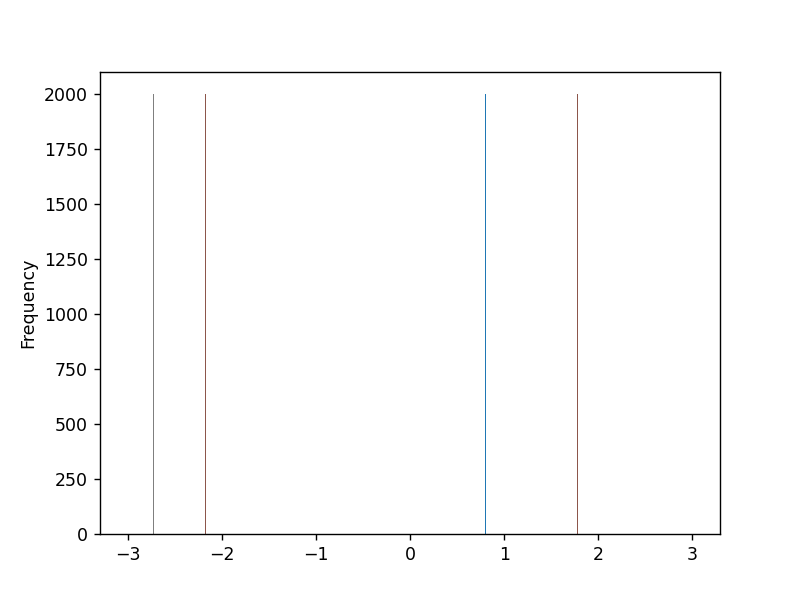

In [239]:
# Plot and investigate. Predictions follow the Laplace distribution, which is very very very nice to see.
plt.hist(z_val, bins = 100, range = (-3,3))
plt.ylabel("Frequency")
plt.show()

In [86]:
z_mean = np.mean(z_val)
z_median = np.median(z_val)
z_max = np.max(z_val)
z_std = np.std(z_val)
std_err_std = np.std(std_err)
z_mean, z_median, z_max, z_std, std_err_std

(2.1023995006321265,
 -0.11213255069927987,
 90.24721123023552,
 8.977397031840756,
 0.14777253762332904)

In [ ]:
z_val = [elem for sublist in z_val for elem in sublist] #unpack
pred = [elem for sublist in pred for elem in sublist] #unpack

In [199]:
# First for the actual data points and then the equispaced grid. First for predictions
df_plot_pred = pd.DataFrame({"latitude": X[:,0].tolist(), "longitude": X[:,1].tolist(), "predicted_value": pred})
df_plot_z = pd.DataFrame({"latitude": X[:,0].tolist(), "longitude": X[:,1].tolist(), "z_val": z_val})

m = folium.Map(location=[mean_lat, mean_lon], zoom_start=13)
heatmap = HeatMap(data=df_plot_z[["latitude", "longitude", "z_val"]].values.tolist(),
                  radius=15)
heatmap.add_to(m)
cmap = cm.LinearColormap(['blue', 'green', 'red'], vmin=df_plot_z['z_val'].min(), vmax=df_plot_z['z_val'].max())
colorbar = cmap.to_step(10)
colorbar.caption = 'Z Values'

# Add the color bar to the map
for i in range(0, 10):
    colorbar.add_to(m)
m

In [210]:
# Binary plot with point if outlier and zero otherwise. To-Do: Write function that extracts the areas where this condition is satisfied.
len(df_plot_z[(abs(df_plot_z["z_val"]) >= 1.96)])

m = folium.Map(location=[mean_lat, mean_lon], zoom_start=13)
heatmap = HeatMap(data=df_plot_z[["latitude", "longitude", "z_val"]].values.tolist(),
                  radius=15)
heatmap.add_to(m)
cmap = cm.LinearColormap(['blue', 'green', 'red'], vmin=df_plot_z['z_val'].min(), vmax=df_plot_z['z_val'].max())
colorbar = cmap.to_step(10)
colorbar.caption = 'Z Values'

# Add the color bar to the map
for i in range(0, 10):
    colorbar.add_to(m)

# Add points to map if prediction > 1.96
for lat, lon, pred in zip(df_plot_z['latitude'], df_plot_z['longitude'], df_plot_z['z_val']):
    if abs(pred) > 1.96:
        folium.CircleMarker(
            location=[lat, lon],
            radius=1,
            color='black',
            fill=True,
            fill_color='black'
        ).add_to(m)
m

In [102]:
latitude_mesh, longitude_mesh = np.meshgrid(X[:,0], X[:,1])
latitude_mesh.shape

# pred_mesh = pred.reshape(latitude_mesh.shape)

# fig = plt.figure()
# ax = fig.gca(projection='3d')
# ax.plot_surface(latitude_mesh, longitude_mesh, pred_mesh, cmap='coolwarm')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Predictions')
# ax.set_title('Regression Surface')
# plt.show()

(2000, 2000)

In [22]:
# Equispaced stuff
min_lat = min(X[:,0])
max_lat = max(X[:,0])
min_lon = min(X[:,1])
max_lon = max(X[:,1])

latitude = np.linspace(min_lat, max_lat, 50)
longitude = np.linspace(min_lon, max_lon, 50)
latitude_mesh, longitude_mesh = np.meshgrid(latitude, longitude)

latitude_vector = latitude_mesh.reshape(-1, 1)
longitude_vector = longitude_mesh.reshape(-1, 1)

#Add points sampled from the dataset
sample_points = df_poll.sample(n=50*50, axis="index")

#Can't predict for points outside the training area
sample_points = sample_points[  (sample_points["lat"].between(min_lat, max_lat)) 
                              & (sample_points["lon"].between(min_lon, max_lon))] 

sample_lat = sample_points["lat"].to_numpy().reshape(-1,1)
sample_lon = sample_points["lon"].to_numpy().reshape(-1,1)

latitude_vector = np.concatenate((latitude_vector, sample_lat))
longitude_vector = np.concatenate((longitude_vector, sample_lon))

pred_equi = model.predict_f(np.hstack((latitude_vector, longitude_vector)))[0].numpy()
std_equi = model.predict_f(np.hstack((latitude_vector, longitude_vector)))[1].numpy()
z_val_equi = compute_z_values(pred_equi, Y, std_equi)

_Note that a handful of points are dropped because they fall outside the training catchment area:_

In [23]:
latitude_vector.shape, longitude_vector.shape, latitude_mesh.shape, pred_equi.shape, std_equi.shape, z_val_equi.shape

((4986, 1), (4986, 1), (50, 50), (4986, 1), (4986, 1), (4986, 1))

In [25]:
plt.imshow(pred_equi, cmap = 'hot', origin='lower', extent=[max_lon, min_lon, max_lat, min_lat])
plt.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Predictions Heatmap')
plt.savefig("pred_heatmap.jpeg")
plt.show()

<IPython.core.display.Javascript object>

_Replaced the equispaced mesh grid with the vector of equispaced points + samples from data_:

In [33]:
#pred_mesh = pred_equi.reshape((latitude_mesh.shape))

latitude_vector = np.squeeze(latitude_vector)
longitude_vector = np.squeeze(longitude_vector)
pred_equi = np.squeeze(pred_equi)

fig = plt.figure()
#ax = fig.gca(projection='3d') <- deprecated in new matplotlib versions
ax = fig.add_subplot(projection="3d")
#ax.plot_surface(latitude_mesh, longitude_mesh, pred_mesh, cmap='coolwarm')
ax.plot_trisurf(latitude_vector, longitude_vector, pred_equi, cmap="coolwarm")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Predictions')
ax.set_title('Regression Surface')
plt.savefig("Regression_surface.jpeg")
plt.show()

<IPython.core.display.Javascript object>

### Set up the Ensemble Workflow

In [7]:
os.chdir("C:/Users/eminu/OneDrive/Desktop/Air-Quality-StatsLab/Data/Rawdata")

In [35]:
df = pd.read_csv("data_cleaned_final.csv")

In [36]:
# Test if the data sampling works
X, Y = stratified_sampling(df = df, p_low = 20, p_high = 80, sample_frac_low = 0.3, sample_frac_medium = 0.4,
                        sample_frac_high = 0.3, add_covariates = False, response = "pm25_detrended_15",
                          size_subsample = 2000)

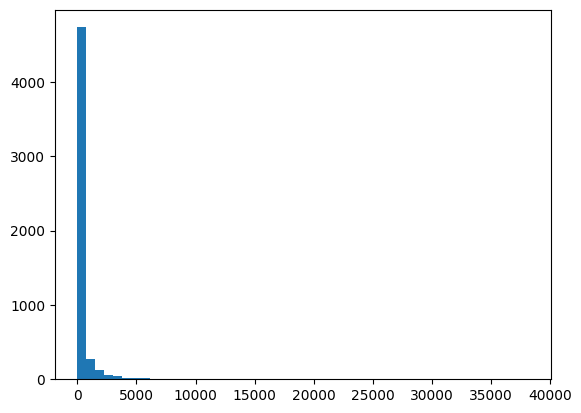

In [38]:
# Find out where we actually have data because if we use an equispaced grid from min lat to max lat and the same for longitude, we 
# get problems because we do not have data there. 
tile_freq = df["tile_id"].value_counts()
plt.hist(tile_freq, bins = 50)
plt.savefig("tile_freq.jpeg")
plt.show()
%matplotlib inline

# Slide window over Kigali and identify a grid that contains e.g. 90% of the observations. Then use that grid for the equispaced 
# grid for predictions. Could start with a square in the middle of the city and make it bigger until it contains 90% of the data. 
# Should not be hard. But I`ll freestyle it quickly go see if it is actually worth it (just look at google maps and use a sensible rectangle)

In [43]:
# Take respective detrended pm25 median. Include in function so no mistakes. Have to load the functions ofc, do not forget. 
median_pm25 = np.median(df[["pm25_detrended_15"]])

num_iterations = 100
predictions = []
variances = []
z_values = []
models = []

for i in range(num_iterations):
    print(f"Iteration {i+1}")
    
    # Data
    X, Y = stratified_sampling(df = df, p_low = 20, p_high = 80, sample_frac_low = 0.3, sample_frac_medium = 0.4,
                        sample_frac_high = 0.3, add_covariates = False, response = "pm25_detrended_15",
                        size_subsample = 2000)
    
    # Initiate model and train it
    model = gpflow.models.GPR(
    (X, Y),
    kernel=gpflow.kernels.Exponential(),
    )
    opt = gpflow.optimizers.Scipy()
    opt.minimize(model.training_loss, model.trainable_variables)
    model.kernel.lengthscales.assign(0.2) #set the lengthscale so it does not go to 0
    gpflow.utilities.print_summary(model, "notebook")
    
    # Predictions, reshape weird nested list. Also compute z_value so we can investigate the difference between
    # averaging the z_values in the end and averaging the predictions and standard errors in the end and then computing the 
    # z values
    pred = model.predict_f(X)[0].numpy()
    pred = np.squeeze(pred)
    #pred = [elem for sublist in pred for elem in sublist]
    
    var = model.predict_f(X)[1].numpy()
    #std_err = [elem for sublist in std_err for elem in sublist]
    z_val = (pred-median_pm25)/np.sqrt(var)
    
    predictions.append(pred)
    variances.append(var)
    z_values.append(z_val)
    models.append(model)

# Now proceed with the ensemble:
# min_lat = np.min(df[["lat"]])
# max_lat = np.max(df[["lat"]])
# min_lon = np.min(df[["lon"]])
# max_lon = np.max(df[["lon"]]) # maybe not good because of sparsity

# # From google maps (just freestyle by taking a rectangle)
min_lat = -1.993033
max_lat = -1.937483
min_lon = 30.041223
max_lon = 30.138396

#Grid sampling for X_test
latitude = np.linspace(min_lat, max_lat, 200)
longitude = np.linspace(min_lon, max_lon, 200)
latitude_grid, longitude_grid = np.meshgrid(latitude, longitude)

#Sampling (lat,lon) pairs from df for X_test
#Remove points not in the training catchment area
sample_points = df.sample(n=200*200, axis="index").reset_index(drop=True)
sample_points = sample_points[  (sample_points["lat"].between(min_lat, max_lat)) 
                              & (sample_points["lon"].between(min_lon, max_lon))] 

sample_lat = sample_points["lat"].to_numpy().reshape(-1)
sample_lon = sample_points["lon"].to_numpy().reshape(-1)

latitude_vector = np.concatenate((latitude_grid.ravel(), sample_lat))
longitude_vector = np.concatenate((longitude_grid.ravel(), sample_lon))

#X_test = np.column_stack((latitude_grid.ravel(), longitude_grid.ravel())) <- previous code
X_test = np.column_stack((latitude_vector, longitude_vector))

# Initialize empty arrays 
mean_values = np.zeros((len(models), X_test.shape[0]))  
var_values = np.zeros((len(models), X_test.shape[0]))  

# Loop over each GP model and compute its predictions on the input points
for i, model in enumerate(models):
    mean, var = model.predict_f(X_test)  # predict mean and variance values
    mean = np.squeeze(mean)
    var = np.squeeze(var)
    mean_values[i, :] = mean  
    var_values[i, :] = var  

# Compute the ensemble mean and variance by taking the average of the predicted values across all GP models. Consider using
# cov_full as we assume that the covariances are zero, 
# otherwise we cannot compute the variance of the sum as the sum of the variances ofc.
ensemble_mean = np.mean(mean_values, axis=0)  
ensemble_var = np.mean(var_values, axis=0)  


'\n# Initialize empty arrays \nmean_values = np.zeros((len(models), X_test.shape[0]))  \nvar_values = np.zeros((len(models), X_test.shape[0]))  \n\n# Loop over each GP model and compute its predictions on the input points\nfor i, model in enumerate(models):\n    mean, var = model.predict_f(X_test)  # predict mean and variance values\n    mean = np.squeeze(mean)\n    var = np.squeeze(var)\n    mean_values[i, :] = mean  \n    var_values[i, :] = var  \n\n# Compute the ensemble mean and variance by taking the average of the predicted values across all GP models. Consider using\n# cov_full as we assume that the covariances are zero, \n# otherwise we cannot compute the variance of the sum as the sum of the variances ofc.\nensemble_mean = np.mean(mean_values, axis=0)  \nensemble_var = np.mean(var_values, axis=0)  \n'

In [71]:
# Save the lists. Could also save the models but not necessary.
np.save("predictions.npy", predictions)
np.save("variances.npy", variances)
np.save("z_values.npy", z_values)
np.save("mean_values.npy", mean_values)
np.save("var_values.npy", var_values)

In [ ]:
# Load the lists etc.
np.load("predictions.npy", allow_pickle=True)

In [66]:
# Save the models just in case
with open("gaussian_process_models.pkl", "wb") as f:
    pickle.dump(models, f)

In [ ]:
# Load the models
with open("gaussian_process_models.pkl", "rb") as f:
    models = pickle.load(f)

In [21]:
# plt.hist(mean_values)
# plt.show()
np.std(mean_values), np.mean(mean_values)
mean_values.shape, var_values.shape
np.transpose(mean_values), mean_values

array([-2.02646076, -2.2599367 , -2.44715746, ...,  8.60938067,
        8.32603051,  8.03298604])

### Plots
Create plots with observations used to fit the GP. Need to save the predictions of the models as pred and compute the z values.
To do so with the ensemble method, you additionally have to save X, Y of course. Not done yet as I want to make that plot for the equispaced grid anyways but this does not work yet as it always predicts 0, which is due to the models setting the lengthscale parameter to $0$ in the optimization, which kind of makes sense intuitively as small length-scales correspond to only very local covariance, meaning that the model takes distant observations not to be correlated. This corresponds to a spikey process (non-smooth), which we want. Lengthscale of $0$ is too extreme however. We need to figure out how to prevent that (I think we can set a range of values we want to explore). A lengthscale $l$ of $0$ means that 
$$k(x,y)=\exp\left(-\frac{\lVert x-y\rVert_1}{\color{red}{l}}\right)$$
we get problems hehe ups. I think this is our main problem and the reason we predict $0$ across the grid. I think that in R where we did not get that issue, the model might not be trained in this fashion and thus is not "tempted" to take $l=0$ as the choice of hyperparameter, because it might actually be what our spikey data suggest or tend to. Maybe we are overfitting. Actually, I have not checked if it internally does some sort of cross-validation or if we just blindely optimize, which would further explain the lengthscale of $0$.


But to use these plot functions now, just use the sampling function once to get X,Y and fit a model and extract predictions and compute z_values and input those.

##### Old plots (the two below)

In [249]:
df_plot_pred = pd.DataFrame({"latitude": X[:,0].tolist(), "longitude": X[:,1].tolist(), "predicted_value": pred})
df_plot_z = pd.DataFrame({"latitude": X[:,0].tolist(), "longitude": X[:,1].tolist(), "z_val": z_val})

m = folium.Map(location=[mean_lat, mean_lon], zoom_start=13)
heatmap = HeatMap(data=df_plot_z[["latitude", "longitude", "z_val"]].values.tolist(),
                  radius=15)
heatmap.add_to(m)
cmap = cm.LinearColormap(['blue', 'green', 'red'], vmin=df_plot_z['z_val'].min(), vmax=df_plot_z['z_val'].max())
colorbar = cmap.to_step(10)
colorbar.caption = 'Z Values'

# Add the color bar to the map
for i in range(0, 10):
    colorbar.add_to(m)
m

In [ ]:
# Binary plot with point if outlier and zero otherwise. To-Do: Write function that extracts the areas where this condition is satisfied.
len(df_plot_z[(abs(df_plot_z["z_val"]) >= 1.96)])

m = folium.Map(location=[mean_lat, mean_lon], zoom_start=13)
heatmap = HeatMap(data=df_plot_z[["latitude", "longitude", "z_val"]].values.tolist(),
                  radius=15)
heatmap.add_to(m)
cmap = cm.LinearColormap(['blue', 'green', 'red'], vmin=df_plot_z['z_val'].min(), vmax=df_plot_z['z_val'].max())
colorbar = cmap.to_step(10)
colorbar.caption = 'Z Values'

# Add the color bar to the map
for i in range(0, 10):
    colorbar.add_to(m)

# Add points to map if prediction > 1.96
for lat, lon, pred in zip(df_plot_z['latitude'], df_plot_z['longitude'], df_plot_z['z_val']):
    if abs(pred) > 1.96:
        folium.CircleMarker(
            location=[lat, lon],
            radius=1,
            color='black',
            fill=True,
            fill_color='black'
        ).add_to(m)
m

##### Plot the result of the ensemble 

In [43]:
# Plots for the ensemble. First create df with predictions and z_values. Plot predictions or z values, just change the name
# of the data frame used and the column name.

# Predictions
mean_val_df = pd.DataFrame(ensemble_mean)
X_test_df = pd.DataFrame(X_test)
df_plot_pred = pd.concat([mean_val_df, X_test_df], axis = 1)
df_plot_pred
df_plot_pred.columns = ["pred", "latitude", "longitude"]

# Z values
z_values = (ensemble_mean-median_pm25)/np.sqrt(ensemble_var)
z_val_df = pd.DataFrame(z_values)
df_plot_z = pd.concat([z_val_df, X_test_df], axis = 1)
df_plot_z.columns = ["z_val", "latitude", "longitude"]

mean_lat = 0.5*(min_lat+max_lat)
mean_lon = 0.5*(min_lon+max_lon)

m = folium.Map(location=[mean_lat, mean_lon], zoom_start=13)
heatmap = HeatMap(data=df_plot_z[["latitude", "longitude", "z_val"]].values.tolist(),
                  radius=15)
heatmap.add_to(m)
cmap = cm.LinearColormap(["blue", "green", "red"], vmin=df_plot_z["z_val"].min(), vmax=df_plot_z["z_val"].max())
colorbar = cmap.to_step(10)
colorbar.caption = "Z Values"

# Add the color bar to the map
for i in range(0, 10):
    colorbar.add_to(m)
    
# Add points to map if prediction > 6 (change back to 1.96 for final stuff)
for lat, lon, z_val in zip(df_plot_z['latitude'], df_plot_z['longitude'], df_plot_z['z_val']):
    if abs(z_val) > 1.96:
        folium.CircleMarker(
            location=[lat, lon],
            radius=0.1,
            color='black',
            fill=True,
            fill_color='black'
        ).add_to(m)
m

In [68]:
# Or simply using the function
plot_ensemble("z_val")

##### Dynamic plot of averaging the regression surfaces
Maybe not worth it. Was thinking of an animation of regression surfaces being combined to the overall one by averaging by a nice 
dynamic plot but prob. completely unnecessary.

In [ ]:
plt.hist(z_values, bins = 50)
plt.show()
len(df_plot_z[(abs(df_plot_z["z_val"]) >= 1.96)])

### Models
We can use the normal GP, the sparse variational inducing point GP and the sparse inducing point GP. The first and the last are very similar but we just choose the inducing points ourselves (but not exactly the same, the model fitting works differently). I have only had luck with the normal GP with the custom resampling. Below are the three methods initialized and the method of training the model is also included. We can use the built-in optimizer from GPFlow or use tensorflow directly - with the advantage of being able to choose how long we want train the model (peform the stoch. gradient descent).

##### Sparse Inducing Point GP
Trained with built in optimization scheme and k-means inducing points.

In [ ]:
n_inducing = 1000
inducing_variable, _ = kmeans(X, n_inducing)

model = gpflow.models.SGPR(
    (X, Y),
    kernel=gpflow.kernels.Exponential(),
    inducing_variable=inducing_variable,
)
opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables)

gpflow.utilities.print_summary(model, "notebook")

##### Sparse Variational Inducing Point GP 
Trained with built in optimization scheme and k-means inducing points.

In [ ]:
n_inducing = 1000
inducing_variable, _ = kmeans(X, n_inducing)

model = gpflow.models.SVGP(
    kernel=gpflow.kernels.Exponential(),
    likelihood=gpflow.likelihoods.Gaussian(),
    inducing_variable=inducing_variable,
)
opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss_closure((X, Y)), model.trainable_variables)

gpflow.utilities.print_summary(model, "notebook")

##### Normal GP
Trained with built in optimization scheme and custom subsampling, i.e. input X,Y from stratified sampling, bad otherwise.

In [ ]:
model = gpflow.models.GPR(
    (X, Y),
    kernel=gpflow.kernels.Exponential(),
)

opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables)

gpflow.utilities.print_summary(model, "notebook")

##### Optimize the model via Tensorflow directly
Choose number of iterations. Can use with all of the models.

In [ ]:
# Train the model using Keras directly so we get to see the progress over the iterations and can
# decide how long we want to train the model. We need to get rid of the lengthscale 0.
opt = tf.keras.optimizers.Adam()

@tf.function
def step() -> tf.Tensor:
    opt.minimize(model.training_loss, model.trainable_variables)

maxiter = 2_000
for i in range(maxiter):
    step()
    if i % 100 == 0:
        print(i, model.training_loss().numpy())

### Explain the model (i.e. where do we have hotspots)
We need to generate the X_test used for the prediction in R as we want to use the function written by Sanelma that gives us the
info about industrial etc. for all the test points (they have to be chosen equally to here ofc). Then use the z-values as Y and X_test as X and look at the influences of the road variables. Works badly.

In [73]:
# Load the testing data (including the industrial indicator etc.)
X_test_covariates = pd.read_csv("X_test.csv")

# Create the linear regression model
linreg = LinearRegression()

# Fit the model to the data using the explanatory variable of interest
X = X_test_covariates[["industrial", "major.road", "res.road"]]
y = (ensemble_mean-median_pm25)/np.sqrt(ensemble_var) #Explain the z-values using the osm indicators
#y = ensemble_mean #explain predictions
linreg.fit(X, y)
print("Coefficients:", linreg.coef_)
print("Intercept:", linreg.intercept_)
print("R-squared:", linreg.score(X, y))

Coefficients: [0.40584363 0.81254924 0.69222566]
Intercept: 0.3482249303943939
R-squared: 0.0065956536627120865


In [14]:
# Do it with statsmodels, its better bc of the nice output. Need to use spatially-robust covariance matrix as the iid assumption
# is ofc. not met. Easily done.

# Fit the model to the data using the explanatory variable of interest
X = X_test_covariates[["industrial", "major.road", "res.road"]]
X = sm.add_constant(X)
y = (ensemble_mean-median_pm25)/np.sqrt(ensemble_var) #Explain the z-values using the osm indicators
#y = ensemble_mean #explain predictions

# Fit the model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     88.52
Date:                Tue, 25 Apr 2023   Prob (F-statistic):           4.38e-57
Time:                        10:42:59   Log-Likelihood:                -64819.
No. Observations:               40000   AIC:                         1.296e+05
Df Residuals:                   39996   BIC:                         1.297e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3482      0.006     56.413      0.0

# To think of
##### Do not forget that we can get the entire covariance matrix of the predicted surface if we use cov_full = True so we know the dependence between predicted points. 

##### Also run a regression (either just linear regression of z_values or logistic regression of binary indicator of hotspot or not on roads, industrial and the third variable that sanelma computed. That allows us to see the relationship between these variables; e.g. we can compute the increase in estimated probability of being a hotspot when a location is in an industrial area vs. not (ceteris paribus of course but still very very nice).

##### Also note that I thought that the GP outputs the standard error but it actually computes the variance. So if it is wrong somewhere above, do not mind. I will do it correctly from now on. 

##### Do everything also with the road variables as predictors.

##### Check if tensorflow optim. is better than standard. Done (No)

### Main problem: See what I wrote under plots (regarding the prediction of only zeros)

In [ ]:
# Maybe still useful
def evaluate_models(models_, grid, independence):
    
    """
        This function takes the dictionary of models from the function fitting_process and evaluates the models
        on the test data and outputs two dictionaries of the same structure containing the predicted values and the variances.
        It also outputs the overall predicted values and variances (averaged over the time brackets)
    
        The arguments are:
        models_fitted: returned dictionary from fitting_process
        grid: sqrt(desired number of test observations)
        independence: if one thinks that the models are independent (e.g. because of subsampling). This affects the variance
                      of the predictions (True or False)
    """
    
    # Make naming consistent
    models_dict = models_fitted
    
    # Now once we have ran all the models, we evaluate them to create the predictions on an equi-spaced grid of test points.
    min_lat = np.min(df["lat"])
    max_lat = np.max(df["lat"])
    min_lon = np.min(df["lon"])
    max_lon = np.max(df["lon"])

    # Increase 200 to get a denser grid of predictions
    latitude = np.linspace(min_lat, max_lat, grid)
    longitude = np.linspace(min_lon, max_lon, grid)
    latitude_grid, longitude_grid = np.meshgrid(latitude, longitude)
    X_test = np.column_stack((latitude_grid.ravel(), longitude_grid.ravel()))

    # Initialize empty arrays
    mean_values_dict = {}
    var_values_dict = {}

    # Loop through models_dict
    for bracket, models in models_dict.items():
        print(f"Evaluating models for bracket: {bracket}")

        # Initialize empty arrays
        mean_values = np.zeros((len(models), X_test.shape[0]))
        var_values = np.zeros((len(models), X_test.shape[0]))

        # Loop over each GP model and compute its predictions on the input points
        for i, model in enumerate(models):
            print(f"Iteration {i+1}")
            mean, var = model.predict_f(X_test)  
            mean = np.squeeze(mean.numpy())
            var = np.squeeze(var.numpy())
            mean_values[i, :] = mean
            var_values[i, :] = var

        # Compute the ensemble mean and variance by taking the average of the predicted values across all GP models
        ensemble_mean = np.mean(mean_values, axis=0)
        if independence == True:
            ensemble_var = np.mean(var_values, axis=0)
        else:
            ensemble_var = np.mean(var_values, axis=0) + np.mean((mean_values - ensemble_mean)**2, axis=0)

        # Save the mean and variance values in the respective dictionary
        mean_values_dict[str(bracket)] = ensemble_mean
        var_values_dict[str(bracket)] = ensemble_var
        
    # Initialize combined mean and variance arrays
    combined_mean = np.zeros(X_test.shape[0])
    combined_variance = np.zeros(X_test.shape[0])

    # Loop through the mean and variance dictionaries for each bracket
    for bracket in brackets:

        # Get the respective mean and variance values
        mean_values_bracket = mean_values_dict[str(bracket)]
        var_values_bracket = var_values_dict[str(bracket)]

        # Accumulate the mean values
        combined_mean += mean_values_bracket

        # Accumulate the variances
        combined_variance += var_values_bracket

    # Divide by the number of brackets to get the average. No just take the average of the variances as we can 
    # rightfully assume that we have independence across time brackets.
    combined_mean /= len(brackets)
    combined_variance /= len(brackets)

    # Compute the z-values
    z_val = (combined_mean-median_pm25)/np.sqrt(combined_variance)

    # Construct csv to return
    df_res = pd.DataFrame({"latitude": X_test[:,0].tolist(), "longitude": X_test[:,1].tolist(),
                           "predicted_value": combined_mean, "predicted_variance": combined_variance,
                           "z_val": z_val})
        
    # Return objects
    return mean_values_dict, var_values_dict, df_res

In [ ]:
# Maybe useful later
# Read in data
df = pd.read_csv("data_cleaned_final.csv")

# Define the detrended pm25 median
median_pm25 = np.median(df["pm25_detrended_15"])

# Depending on the processing, you may need to adjust the datetime variable here so you just have the daytime.
df["datetime"] = df["datetime"].str.rstrip("Z")
df["datetime"] = pd.to_datetime(df["datetime"]).dt.time

# Initialize empty dictionaries to save models
models_dict = {}

# Number of iterations
num_iterations = 100

# Define the 2-hour brackets and the period of interest. If you want equal brackets through-out the entire day, use this. To make
# night-time one bracket as we do not have a lot of data there, create the brackets as done below.
# brackets = pd.date_range(start="00:00:00", end="24:00:00", freq="2H").time
brackets = [
    pd.to_datetime("06:00:00").time(),
    pd.to_datetime("08:00:00").time(),
    pd.to_datetime("10:00:00").time(),
    pd.to_datetime("12:00:00").time(),
    pd.to_datetime("14:00:00").time(),
    pd.to_datetime("16:00:00").time(),
    pd.to_datetime("18:00:00").time()
]

# Run the ensemble for all brackets seperately
for bracket in brackets:
    print(f"Bracket: {bracket}")
    
    # Filter the data for the current bracket
    df_bracket = df[df["datetime"].apply(lambda x: x.hour == bracket.hour)]
    
    # Initialize a list to save models for the current bracket
    models = []
    
    # Only run num_iteration / number of brackets per bracket as we take num_iterations to be the total number of fitted models
    for i in range(int(num_iterations/len(brackets))):
        print(f"Iteration {i+1}")
        
        # Sample data
        X, Y = stratified_sampling(df=df_bracket, p_low=20, p_high=80, sample_frac_low=0.3, sample_frac_medium=0.4,
                                   sample_frac_high=0.3, add_covariates=False, response="pm25_detrended_15",
                                   size_subsample=2000)
        
        # Initiate model and train it. The optimization sets l = 0, which creates algebraic issues so we set it to 0.1. 
        k = gpflow.kernels.Exponential()
        model = gpflow.models.GPR((X, Y), kernel=k)
        opt = gpflow.optimizers.Scipy()
        opt.minimize(model.training_loss, model.trainable_variables)
        model.kernel.lengthscales.assign(0.1)  
        gpflow.utilities.print_summary(model, "notebook")
        
        # Save the model
        models.append(model)
        
    # Save the model into the dict so we can access using bracket name
    models_dict[str(bracket)] = models